Epoch [10/1000], Loss: 0.0049
Epoch [20/1000], Loss: 0.0048
Epoch [30/1000], Loss: 0.0046
Epoch [40/1000], Loss: 0.0046
Epoch [50/1000], Loss: 0.0045
Epoch [60/1000], Loss: 0.0041
Epoch [70/1000], Loss: 0.0037
Epoch [80/1000], Loss: 0.0037
Epoch [90/1000], Loss: 0.0036
Epoch [100/1000], Loss: 0.0036
Epoch [110/1000], Loss: 0.0036
Epoch [120/1000], Loss: 0.0036
Epoch [130/1000], Loss: 0.0035
Epoch [140/1000], Loss: 0.0035
Epoch [150/1000], Loss: 0.0034
Epoch [160/1000], Loss: 0.0033
Epoch [170/1000], Loss: 0.0031
Epoch [180/1000], Loss: 0.0034
Epoch [190/1000], Loss: 0.0035
Epoch [200/1000], Loss: 0.0036
Epoch [210/1000], Loss: 0.0035
Epoch [220/1000], Loss: 0.0034
Epoch [230/1000], Loss: 0.0031
Epoch [240/1000], Loss: 0.0029
Epoch [250/1000], Loss: 0.0027
Epoch [260/1000], Loss: 0.0025
Epoch [270/1000], Loss: 0.0024
Epoch [280/1000], Loss: 0.0039
Epoch [290/1000], Loss: 0.0036
Epoch [300/1000], Loss: 0.0034
Epoch [310/1000], Loss: 0.0032
Epoch [320/1000], Loss: 0.0030
Epoch [330/1000],

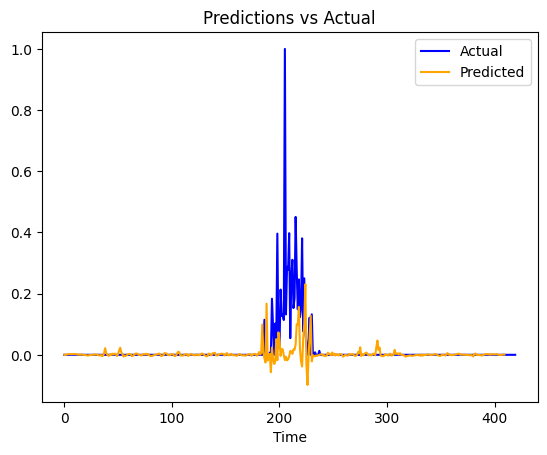

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load and preprocess the data
data = pd.read_csv('weather_data2.csv')
data = (data - data.min()) / (data.max() - data.min())
data = torch.tensor(data.values, dtype=torch.float32)


# Split the data into training and testing sets
split_index = int(len(data) * 0.80)
train_data = data[:split_index]
test_data = data[split_index:]

# Prepare the training data
seq_length = 10
train_sequences = []
train_labels = []
for i in range(len(train_data) - seq_length):
    train_sequences.append(train_data[i:i+seq_length])
    train_labels.append(train_data[i+seq_length, -1])  # Use the last column as the target
train_sequences = torch.stack(train_sequences)
train_labels = torch.stack(train_labels)

# Prepare the testing data
test_sequences = []
test_labels = []
for i in range(len(test_data) - seq_length):
    test_sequences.append(test_data[i:i+seq_length])
    test_labels.append(test_data[i+seq_length, -1])  # Use the last column as the target
test_sequences = torch.stack(test_sequences)
test_labels = torch.stack(test_labels)

# Define the model hyperparameters
input_size = train_sequences.shape[2]
hidden_size = 32
num_layers = 2
output_size = 1  # Since we are predicting a single column

num_epochs = 1000
learning_rate = 0.01

# Initialize the LSTM model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_sequences)
    loss = criterion(outputs.squeeze(), train_labels)  # Squeeze the output tensor to match the shape of train_labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Switch the model to evaluation mode
model.eval()

# Prepare the testing data
test_sequences = []
test_labels = []
for i in range(len(test_data) - seq_length):
    test_sequences.append(test_data[i:i+seq_length])
    test_labels.append(test_data[i+seq_length])
test_sequences = torch.stack(test_sequences)
test_labels = torch.stack(test_labels)

# Make predictions on the test data
with torch.no_grad():
    test_predictions = model(test_sequences)

# Denormalize the data
denormalized_predictions = test_predictions * (data[:, -1].max() - data[:, -1].min()) + data[:, -1].min()
denormalized_actual = test_data[:, -1] * (data[:, -1].max() - data[:, -1].min()) + data[:, -1].min()

# Plot the predictions (orange line) and the actual values (blue line)
plt.plot(denormalized_actual, color='blue', label='Actual')
plt.plot(denormalized_predictions, color='orange', label='Predicted')

# Set x-axis label and title
plt.xlabel('Time')
plt.title('Predictions vs Actual')

# Display legend
plt.legend()

# Show the plot
plt.show()


